# Local Polynomial Resampling Examples

In [1]:
# Initial imports
from sofia_redux.toolkit.resampling.resample import Resample
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

## The window and smoothing parameters

The following example uses local polynomial resampling to smooth a couple of noisy functions.  The `window` parameter sets the width of the resampling window in units of `x` around each output point (in this case, the output coordinates are the same as the input coordinates).

The `smoothing` parameter is a fraction of `window` by which to weight sample points as distance increases from the each resampling point.  Data are weighted according to
$$e^{-(\frac{x_i - x_j}{\omega\sqrt{\alpha}})^{2}} $$

Where $x_i$ is a resampling coordinate, $x_j$ is a sample coordinate, `smoothing`=$\alpha$ and `window`=$\omega$

- The following code allows interaction with the window and smoothing parameters to visualize the result.  Note that the resampling is achieved in the first line of `adjust_window_smoothing`, the rest is just plotting.

In [2]:
def adjust_window_smoothing(window, smoothing):
    smoothed = Resample(x0, y0, window=window)(x0, smoothing=smoothing)
    plt.plot(x0, smoothed.T)
    plt.ylim(-1.2, 1.2)
    plt.title("Resampled using window=%f, smoothing=%f" %
              (window, smoothing))
    
def interact_with_window():
    interact(adjust_window_smoothing,
             window=widgets.FloatSlider(
                 min=np.pi / 1000, max=0.9, step=0.01, value=0.5),
             smoothing=widgets.FloatSlider(
                 min=0.0, max=1.0, step=0.1, value=0.5))

- Create some noisy test data.  Note that we can create multiple sets of data if they all share the same sample coordinates.  Here we create a sin and cosine function on the same coordinate grid:

In [3]:
x0 = np.linspace(0, 4 * np.pi, 1000)
y0 = np.vstack([np.sin(x0), np.cos(x0)])

# Add noise
random = np.random.RandomState(41)
y0 += random.normal(loc=0, scale=0.1, size=y0.size).reshape(y0.shape)

- Plot the noisy data:

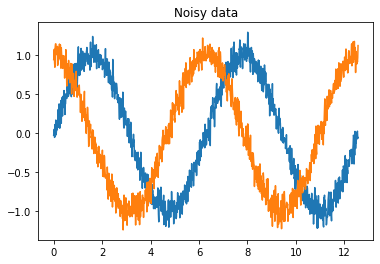

In [4]:
plt.plot(x0, y0.T)
_ = plt.title('Noisy data')

Use the following cell to generate the resample the noisy data on-the-fly.  Increasing `window` will effectivly increase the number of samples used to resample each output coordinate.  A `smoothing` value of zero will disable distance weighting, while smaller values will result in a shaper fit since samples close to each resampling point will be weighted more heavily.

Note that if `window` is set to zero, all data will be set to NaN as no samples can be placed inside a zero-width window.

In [5]:
# Create the plot
interact_with_window()

interactive(children=(FloatSlider(value=0.5, description='window', max=0.9, min=0.0031415926535897933, step=0.…

## Order

By default, Resample uses a polynomial fit order of 1.  Each dimension may be resampled using a different order if required.

- Here we create a square to analyse the edge affects with respect to order which is allowed to vary across both dimensions.

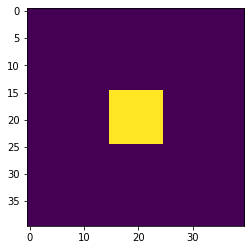

In [6]:
y1, x1 = np.mgrid[:40, :40]
data1 = np.zeros(x1.shape)
data1[15:25, 15:25] = 1
coordinates1 = np.vstack([z.ravel() for z in [x1, y1]])
_ = plt.imshow(data1)

The following code creates a profile across the center of the square along both dimensions (x, y), allows the user to update `order` and plots the result.  Please note the following:

- We are using a fixed smoothing parameter of 0.3 pixels, i.e. not relative to `window` by specifying `relative_smooth=False`.
- `mode='extrapolate'` means that we check that there are enough unique coordinates in both dimensions for each resampling point.  The default mode (`'edges'`) checks that there are enough unique sample points to the "left" and "right" of each resampling point.  'edges' mode (while more robust to singular matrix errors) would otherwise cause NaN values under certain conditions.

In [7]:
x_cross = np.linspace(10, 31, 40), 20.0
y_cross = 20.0, np.linspace(10, 31, 40)

def update_order(x_order, y_order):
    order = np.array([x_order, y_order])
    resampler = Resample(coordinates1, data1.ravel(), order=order,
                         mode='extrapolate')
    col_data = resampler(*x_cross, smoothing=1, relative_smooth=False)
    row_data = resampler(*y_cross, smoothing=1, relative_smooth=False)
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(x_cross[0], col_data[0])
    plt.plot(np.arange(10, 31), data1[10:31, 20], '.', color='red')
    plt.title('Cross-section in X; order=%i' % x_order)
    plt.subplot(1, 2, 2)
    plt.plot(y_cross[1], row_data[:, 0])
    plt.plot(np.arange(10, 31), data1[20, 10:31], '.', color='red')
    _ = plt.title('Cross-section in Y; order=%i' % y_order)

    
def interact_with_order():
    interact(update_order,
         x_order=widgets.IntSlider(min=0, max=5, step=1, value=3),
         y_order=widgets.IntSlider(min=0, max=5, step=1, value=3))
    
    

Create the plot.  Note the deviations near the edges generally increase with higher orders.  This is a consequence of trying to fit polynomials to clean data with sharp edges.

In [8]:
interact_with_order()

interactive(children=(IntSlider(value=3, description='x_order', max=5), IntSlider(value=3, description='y_orde…

## Thresholding Parameters

There are three thresholding parameters available to clean the data:

1. `negthresh` operates on the input data, masking out all data (over each dataset) such that $$\forall{z},\, z>-negthresh * \sigma_{z}$$ where $z$ is the data to be fitted and $\sigma_{z}$ is the standard deviation of the data.
2. `robust` operates on the input data, masking out all data (over each dataset) such that $$\forall{z},\, \frac{\left|z - \tilde{z}\right|}{MAD}$$ where $z$ is the data to be fitted, $\tilde{z}$ is the median of the data and $MAD$ is the Median Absolute Deviation of the data given by: $$1.482 * \tilde{\left|z - \tilde{z}\right|}$$
3. `fit_threshold` operates on the fitted data (accessed during `__call__`) and will reject any fits such that $$\forall{d_{fit}},\, \left|d_{fit}-\bar{d_{samples}}\right| < threshold * \sigma_{d_{samples}}$$
Values that could not be fit are replaced by the weighted mean of the samples used to fit each point.

By default, all thresholding parameters are turned off.  However, it should be noted that no NaN values (or zero valued errors) are allowed to propagate through to the fitting stage.  If any are found, they will be masked out.

### Negthresh Example

In [9]:
x2 = np.linspace(0, 10, 1000) - 5
# Ensure the y value goes below zero
y2 = 0.5 * x2 ** 2 - 3

# All data below -1e3 * std(data) is masked out prior to fitting
resampled2 = Resample(x2, y2, negthresh=1e-3)(x2)

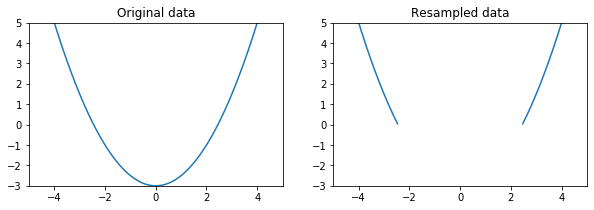

In [10]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(x2, y2)
plt.xlim(-5, 5)
plt.ylim(-3, 5)
plt.title("Original data")
plt.subplot(1, 2, 2)
plt.plot(x2, resampled2)
plt.xlim(-5, 5)
plt.ylim(-3, 5)
_ = plt.title("Resampled data")

### Robust Example

In [11]:
x3 = np.linspace(0, 10, 100)
random = np.random.RandomState(41)
y3 = random.rand(100) - 0.5

# add outliers
y3[25] = 1000
y3[75] = 2000

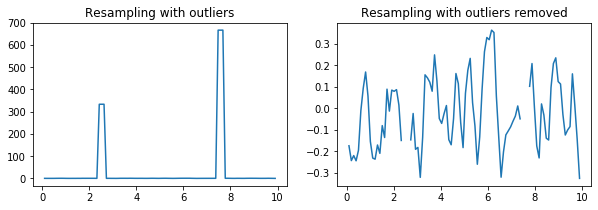

In [12]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
r3 = Resample(x3, y3)(x3)
plt.plot(x3, r3)
plt.title("Resampling with outliers")
plt.subplot(1, 2, 2)
r3_removed = Resample(x3, y3, robust=3)(x3)
plt.plot(x3, r3_removed)
_ = plt.title("Resampling with outliers removed")

### fit_threshold Example

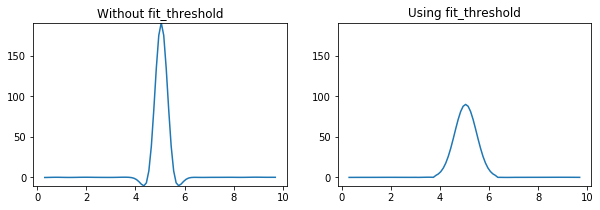

In [13]:
x4 = np.linspace(0, 10, 100)
random = np.random.RandomState(41)
y4 = random.rand(100) - 0.5

# add an outlier that we will actually fit on
y4[50] = 1000
r4 = Resample(x4, y4, window=2, order=3)(x4, smoothing=0.1)
ylim = np.nanmin(r4), np.nanmax(r4)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(x4, r4)
plt.ylim(*ylim)
plt.title("Without fit_threshold")

# Remove outlier post fitting and replace with mean
plt.subplot(1, 2, 2)
r4_removed = Resample(x4, y4, window=2, order=3)(
    x4, fit_threshold=0.01, smoothing=0.1)
plt.plot(x4, r4_removed)
plt.ylim(*ylim)
_ = plt.title("Using fit_threshold")

# Reduced but not great.  If you've got an example that produces bad
# polynomial fits, let me know!  The plot below using fit_threshold is
# probably just the weighted mean of the window.